## Importing Libraries

In [51]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Reading in Data 
(One .CSV per Year, Approximately Hourly Update)

In [52]:
# data is from 2000 to 2022
# reading files from 'hourly_historical_chi_weather' folder
chi_hrly = []
chi_hrly = pd.DataFrame()
for i in range(1,24):
    temp_df = pd.read_csv('hourly_historical_chi_weather/72534014819 ({}).csv'.format(i))
    chi_hrly = chi_hrly.append(temp_df, ignore_index=True)

## Data Exploration

In [53]:
# rows and columns of the dataframe
chi_hrly.shape

(317020, 116)

In [54]:
# head of the dataframe
chi_hrly.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,GK1,GP1,GQ1,GR1,IA1,SA1,UA1,UG1,AA4,ME1
0,72534014819,2013-01-01T00:49:00,6,41.78611,-87.75222,186.5,"CHICAGO MIDWAY AIRPORT, IL US",FM-16,KMDW,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72534014819,2013-01-01T00:51:00,7,41.78611,-87.75222,186.5,"CHICAGO MIDWAY AIRPORT, IL US",FM-15,KMDW,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72534014819,2013-01-01T01:51:00,7,41.78611,-87.75222,186.5,"CHICAGO MIDWAY AIRPORT, IL US",FM-15,KMDW,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72534014819,2013-01-01T02:51:00,7,41.78611,-87.75222,186.5,"CHICAGO MIDWAY AIRPORT, IL US",FM-15,KMDW,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,72534014819,2013-01-01T03:00:00,4,41.78611,-87.75222,186.5,"CHICAGO MIDWAY AIRPORT, IL US",FM-12,KMDW,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

Converting the dataframe 'chi_hrly' 'DATE' column to a pd.datetime format and sorting by date. 

In [55]:
chi_hrly['DATE'] = pd.to_datetime(chi_hrly['DATE'], yearfirst=True).sort_values().reset_index(drop=True)

Ensuring that the sorting actually worked.

In [56]:
chi_hrly['DATE'].head()

0   2000-01-01 00:00:00
1   2000-01-01 00:53:00
2   2000-01-01 01:00:00
3   2000-01-01 01:53:00
4   2000-01-01 02:00:00
Name: DATE, dtype: datetime64[ns]

In [57]:
chi_hrly['TMP']

0         -0030,5
1         -0033,5
2         -0033,5
3         -0028,5
4         -0028,1
           ...   
317015    -0040,1
317016    +9999,9
317017    -0040,1
317018    +9999,9
317019    -0040,1
Name: TMP, Length: 317020, dtype: object

In [58]:
# splitting 'TMP' by the comma into two columns: TMP_F and TMP_Confidence
chi_hrly['TMP_F'],chi_hrly['TMP_Confidence'] = chi_hrly['TMP'].str.split(',',1).str

In [59]:
# number of rows with TMP_F = '+9999' which indicates missing data
chi_hrly[chi_hrly['TMP_F'] == '+9999'].shape[0] / chi_hrly.shape[0]

# converting rows where TMP_F = '+9999' to NaN
chi_hrly['TMP_F'] = chi_hrly['TMP_F'].replace('+9999', np.nan)

# converting 'TMP_F' to float (and from celsius to fahrenheit) if not NaN
# this is factoring in for the scaling factor of 10, thus the division by 10
chi_hrly['TMP_F'] = (chi_hrly['TMP_F'].astype(float)/10 * 9/5) + 32

# converting 'TMP_Confidence' to int
chi_hrly['TMP_Confidence'] = chi_hrly['TMP_Confidence'].astype(int)

In [60]:
# total number of days with missing data
print('total number of missing weather observations:',chi_hrly['TMP_F'].isna().sum())

# total number of days with missing data
print('percentage of missing weather observations:',round(chi_hrly['TMP_F'].isna().sum()/ chi_hrly.shape[0],4)*100,'%')

total number of missing weather observations: 50256
percentage of missing weather observations: 15.85 %


In [61]:
chi_hrly['TMP_Confidence'].value_counts()

5    188523
1     77333
9     50256
7       860
6        45
2         3
Name: TMP_Confidence, dtype: int64

- Should probably make TMP_F be NA for all 9's in TMP_Confidence (which is likely already the case.)
- 7, 6, 3 & 2 should be NaNs
- 5 and 1 are OK

In [33]:
chi_hrly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317020 entries, 0 to 317019
Columns: 118 entries, STATION to TMP_Confidence
dtypes: datetime64[ns](1), float64(4), int64(2), object(111)
memory usage: 285.4+ MB


There are 118 columns in this dataset, which is too many for the .info() function to be useful.

In [62]:
chi_hrly['STATION'].value_counts() # SAME FOR ALL

72534014819    317020
Name: STATION, dtype: int64

In [63]:
#chi_hrly['STATION'].value_counts() # SAME FOR ALL
#chi_hrly['LATITUDE'].value_counts() # SIMILAR/SAME FOR ALL
#chi_hrly['REPORT_TYPE'].value_counts() # NOT SAME FOR ALL
chi_hrly['MW2'].nunique()


44

If there is no response variable value (TMP_F or temperature in Fahrenheit) the observation doesn't have much value, so it is removed below.

In [64]:
# dropping TMP_F where NA
chi_hrly = chi_hrly.dropna(subset=['TMP_F'])

#### Data Cleaning For Loop Function

- Input
    - Dataframe
    - Missing value threshold for column removal
    - number of unique values threshold
- Output
    - Columns that have only one value removed
    - Columns that have

In [67]:
def removing_useless_columns(df, na_theshold=0.99, unique_threshold=1):
    df = df.copy()
    unique_violations = 0
    na_violations = 0
    for col in df.columns:
        if df[col].isna().sum()/df.shape[0] >= na_theshold:
            na_violations += 1
            df.drop(col, axis=1, inplace=True)
        elif df[col].nunique() <= unique_threshold:
            unique_violations += 1
            df.drop(col, axis=1, inplace=True)
    print('Unique Violations:',unique_violations)
    print('NA Violations:',na_violations)
    return df 


In [68]:
print(chi_hrly.shape)
chi_hrly_cleaned = removing_useless_columns(chi_hrly)
print(chi_hrly_cleaned.shape)

(266764, 118)
Unique Violations: 3
NA Violations: 70
(266764, 45)


In [69]:
prct_missing = []
# for loop that goes through each column and calculates the percentage of missing data
for col in chi_hrly_cleaned.columns:
    prct_missing.append(chi_hrly_cleaned[col].isna().sum()/chi_hrly_cleaned.shape[0])
# turning the list into a dataframe
prct_missing = pd.DataFrame(prct_missing, index=chi_hrly_cleaned.columns, columns=['prct_missing'])
prct_missing.sort_values(by='prct_missing', ascending=False)

,prct_missing
AW3,0.989035
AJ1,0.987892
ED1,0.987637
KA4,0.987120
KA3,0.986932
GD4,0.970345
MW2,0.949176
OD1,0.937102
AA2,0.934493
AU2,0.917931


I'm quite curious as to why ELEVATION, LONGITUDE, and LATITUDE didn't meet the requirements of having only one unique value.

In [73]:
chi_hrly_cleaned['ELEVATION'].value_counts()

186.5    243250
185.8     23514
Name: ELEVATION, dtype: int64

In [74]:
chi_hrly_cleaned['LONGITUDE'].value_counts()

-87.75222    243250
-87.75514     23514
Name: LONGITUDE, dtype: int64

In [75]:
chi_hrly_cleaned['LATITUDE'].value_counts()

41.78611    243250
41.78412     23514
Name: LATITUDE, dtype: int64

Interestingly, it looks like there are two observation points. I am going to operate under the assumption that there is no difference between the two obervation points since they seem to be so close to one another. I'm not entirely sure that this a good assumption, but for the purposes of this project, I am fine making it.

In [77]:
print(chi_hrly_cleaned.shape)
chi_hrly_cleaned = removing_useless_columns(chi_hrly_cleaned, na_theshold=0.01, unique_threshold=1)
print(chi_hrly_cleaned.shape)

(266764, 45)
Unique Violations: 0
NA Violations: 28
(266764, 17)


I am dropping all values with basically any missing value rate I think the class of model that I am building won't be that complex.

In [79]:
chi_hrly_cleaned.head()

,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,REPORT_TYPE,CALL_SIGN,WND,CIG,VIS,TMP,DEW,SLP,MA1,REM,TMP_F,TMP_Confidence
0,2000-01-01 00:00:00,6,41.78611,-87.75222,186.5,FM-16,KMDW,"310,5,N,0031,5","00610,5,M,N","016093,5,N,5","-0030,5","-0080,5","99999,9","10183,5,09958,5",MET09512/31/12 18:49:03 SPECI KMDW 010049Z 310...,26.60,5
1,2000-01-01 00:53:00,7,41.78611,-87.75222,186.5,FM-15,KMDW,"310,5,N,0031,5","00610,5,M,N","016093,5,N,5","-0033,5","-0078,5","10197,5","10186,5,09961,5",MET10712/31/12 18:51:03 METAR KMDW 010051Z 310...,26.06,5
2,2000-01-01 01:00:00,7,41.78611,-87.75222,186.5,FM-15,KMDW,"290,5,N,0026,5","00610,5,M,N","014484,5,N,5","-0033,5","-0078,5","10200,5","10190,5,09965,5",MET09912/31/12 19:51:03 METAR KMDW 010151Z 290...,26.06,5
3,2000-01-01 01:53:00,7,41.78611,-87.75222,186.5,FM-15,KMDW,"360,5,N,0041,5","00610,5,M,N","011265,5,N,5","-0028,5","-0083,5","10197,5","10186,5,09961,5",MET10512/31/12 20:51:03 METAR KMDW 010251Z 360...,26.96,5
4,2000-01-01 02:00:00,4,41.78611,-87.75222,186.5,FM-12,KMDW,"360,1,N,0041,1","99999,9,9,N","011000,1,N,1","-0028,1","-0083,1","10197,1","99999,9,09961,1",SYN076AAXX 01034 72534 32561 83608 11028 2108...,26.96,1


## EDA

Text(0, 0.5, 'Temperature (F)')

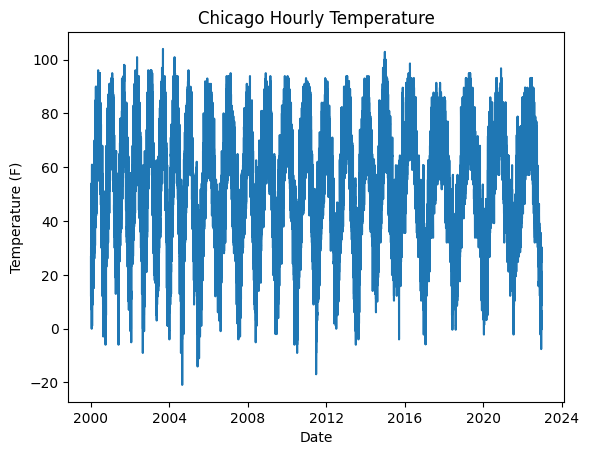

In [80]:
# df with only time and TMP_F 'temp in Fahrenheit'
chi_tmp_time = chi_hrly_cleaned[['DATE','TMP_F']]
chi_tmp_time = chi_tmp_time[abs(chi_tmp_time['TMP_F']) < 200]
chi_tmp_time.shape
chi_tmp_time.head()
plt.plot(chi_tmp_time['DATE'],chi_tmp_time['TMP_F'])
plt.title('Chicago Hourly Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

(array([1.4000e+01, 1.3000e+01, 9.0000e+00, 2.8000e+01, 1.8000e+01,
        4.3000e+01, 4.0000e+01, 9.1000e+01, 1.4900e+02, 3.2500e+02,
        6.5500e+02, 6.2900e+02, 6.2000e+02, 8.7600e+02, 1.1480e+03,
        1.8570e+03, 1.6290e+03, 2.1960e+03, 2.5410e+03, 3.5530e+03,
        3.7230e+03, 5.2750e+03, 7.2840e+03, 7.1590e+03, 8.4310e+03,
        8.4980e+03, 1.0127e+04, 8.6980e+03, 1.0698e+04, 7.1110e+03,
        7.7840e+03, 7.9540e+03, 7.9200e+03, 7.4030e+03, 9.1530e+03,
        9.7760e+03, 6.6290e+03, 6.9880e+03, 6.1970e+03, 7.4560e+03,
        9.8990e+03, 8.4840e+03, 7.9830e+03, 9.6080e+03, 1.0183e+04,
        1.0054e+04, 8.6500e+03, 1.0750e+04, 5.6650e+03, 4.7900e+03,
        3.5210e+03, 2.3860e+03, 1.8140e+03, 1.2890e+03, 5.7100e+02,
        2.4600e+02, 9.3000e+01, 4.6000e+01, 2.4000e+01, 1.0000e+01]),
 array([-2.09200e+01, -1.88380e+01, -1.67560e+01, -1.46740e+01,
        -1.25920e+01, -1.05100e+01, -8.42800e+00, -6.34600e+00,
        -4.26400e+00, -2.18200e+00, -1.00000e-01,  1.9

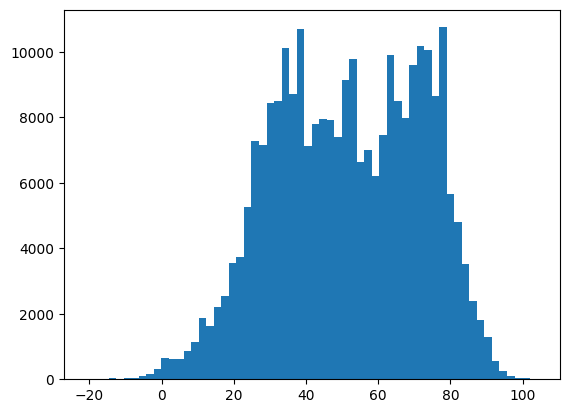

In [81]:
# plot this distribution of 'TMP_F'
plt.hist(chi_tmp_time['TMP_F'], bins=60)

## Modeling Section

In the base case of my model, I am only going to use the date/time and tmp_f, which is only two columns.

In [82]:
chi_hrly_basic = chi_hrly_cleaned[['DATE', 'TMP_F']]

,DATE,TMP_F
0,2000-01-01 00:00:00,26.60
1,2000-01-01 00:53:00,26.06
2,2000-01-01 01:00:00,26.06
3,2000-01-01 01:53:00,26.96
4,2000-01-01 02:00:00,26.96
